<a href="https://colab.research.google.com/github/Tushar1858/Ucs547/blob/main/UCS547_ASSIGNMENT3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Name:Tushar  
Roll no:102303206  
UCS547



Q1: Write a CUDA C/C++ program to perform element-wise addi;on of two vectors.  

C[i]=A[i]+B[i].

Given: Vector size: N = 1024

In [2]:
%%writefile vector_add.cu
#include <stdio.h>
#include <cuda_runtime.h>

#define N 1024

/* Device Code (GPU Kernel) */
__global__ void vectorAdd(int *A, int *B, int *C) {
    int i = blockIdx.x * blockDim.x + threadIdx.x;
    if (i < N) {
        C[i] = A[i] + B[i];
    }
}

/* Host Code (CPU) */
int main() {

    int h_A[N], h_B[N], h_C[N];
    int *d_A, *d_B, *d_C;

    // Initialize host vectors
    for(int i = 0; i < N; i++) {
        h_A[i] = i;
        h_B[i] = i * 2;
    }

    // Allocate device memory
    cudaMalloc((void**)&d_A, N * sizeof(int));
    cudaMalloc((void**)&d_B, N * sizeof(int));
    cudaMalloc((void**)&d_C, N * sizeof(int));

    // Copy data to device
    cudaMemcpy(d_A, h_A, N * sizeof(int), cudaMemcpyHostToDevice);
    cudaMemcpy(d_B, h_B, N * sizeof(int), cudaMemcpyHostToDevice);

    // Launch kernel
    vectorAdd<<<(N+255)/256, 256>>>(d_A, d_B, d_C);
    cudaDeviceSynchronize();

    // Copy result back to host
    cudaMemcpy(h_C, d_C, N * sizeof(int), cudaMemcpyDeviceToHost);

    // Print first 10 results
    printf("First 10 Results:\n");
    for(int i = 0; i < 10; i++) {
        printf("C[%d] = %d\n", i, h_C[i]);
    }

    // Free device memory
    cudaFree(d_A);
    cudaFree(d_B);
    cudaFree(d_C);

    return 0;
}

Writing vector_add.cu


In [3]:
!nvcc -arch=sm_75 -std=c++11 -Wno-deprecated-gpu-targets vector_add.cu -o vector_add

In [4]:
!./vector_add

First 10 Results:
C[0] = 0
C[1] = 3
C[2] = 6
C[3] = 9
C[4] = 12
C[5] = 15
C[6] = 18
C[7] = 21
C[8] = 24
C[9] = 27


Q2:  Perform the same vector addition as in Q1 using Thrust library only.

In [7]:
%%writefile thrust_vector_add.cu
#include <iostream>
#include <thrust/device_vector.h>
#include <thrust/host_vector.h>
#include <thrust/transform.h>

#define N 1024

int main() {

    thrust::device_vector<int> A(N);
    thrust::device_vector<int> B(N);
    thrust::device_vector<int> C(N);

    for(int i = 0; i < N; i++) {
        A[i] = i;
        B[i] = i * 2;
    }

    thrust::transform(A.begin(), A.end(),
                      B.begin(),
                      C.begin(),
                      thrust::plus<int>());

    thrust::host_vector<int> h_C = C;

    std::cout << "First 10 Results:\n";
    for(int i = 0; i < 10; i++) {
        std::cout << "C[" << i << "] = " << h_C[i] << std::endl;
    }

    return 0;
}

Overwriting thrust_vector_add.cu


In [8]:
!nvcc -arch=sm_75 -std=c++11 thrust_vector_add.cu -o thrust_vector_add

In [9]:
!./thrust_vector_add

First 10 Results:
C[0] = 0
C[1] = 3
C[2] = 6
C[3] = 9
C[4] = 12
C[5] = 15
C[6] = 18
C[7] = 21
C[8] = 24
C[9] = 27


Q3: Compute the dot product of two vectors of size, N =1024: Result=∑A[i]×B[i]
using Thrust and compare its performance with that on CPU.

In [10]:
%%writefile thrust_dot_product.cu
#include <iostream>
#include <thrust/device_vector.h>
#include <thrust/host_vector.h>
#include <thrust/inner_product.h>
#include <chrono>

#define N 1024

int main() {

    // ---------------- CPU PART ----------------
    int h_A[N], h_B[N];

    for(int i = 0; i < N; i++) {
        h_A[i] = i;
        h_B[i] = i * 2;
    }

    auto cpu_start = std::chrono::high_resolution_clock::now();

    long long cpu_result = 0;
    for(int i = 0; i < N; i++)
        cpu_result += h_A[i] * h_B[i];

    auto cpu_end = std::chrono::high_resolution_clock::now();
    double cpu_time = std::chrono::duration<double, std::milli>(cpu_end - cpu_start).count();

    // ---------------- GPU (THRUST) PART ----------------
    thrust::device_vector<int> d_A(h_A, h_A + N);
    thrust::device_vector<int> d_B(h_B, h_B + N);

    auto gpu_start = std::chrono::high_resolution_clock::now();

    long long gpu_result = thrust::inner_product(d_A.begin(), d_A.end(),
                                                 d_B.begin(),
                                                 0LL);

    cudaDeviceSynchronize();

    auto gpu_end = std::chrono::high_resolution_clock::now();
    double gpu_time = std::chrono::duration<double, std::milli>(gpu_end - gpu_start).count();

    // ---------------- OUTPUT ----------------
    std::cout << "CPU Dot Product Result: " << cpu_result << std::endl;
    std::cout << "GPU (Thrust) Dot Product Result: " << gpu_result << std::endl;

    std::cout << "CPU Time (ms): " << cpu_time << std::endl;
    std::cout << "GPU Time (ms): " << gpu_time << std::endl;

    return 0;
}

Writing thrust_dot_product.cu


In [11]:
!nvcc -arch=sm_75 -std=c++11 thrust_dot_product.cu -o thrust_dot_product

In [12]:
!./thrust_dot_product

CPU Dot Product Result: 714779648
GPU (Thrust) Dot Product Result: 714779648
CPU Time (ms): 0.0025
GPU Time (ms): 0.557008


Q4: Write a CUDA kernel formatrix multiplication:C=A×B where  Matrix size is 16 X 16. Explain why matrix multiplication needs more computation than
addition (as in Q1).


In [13]:
%%writefile matrix_mul.cu
#include <stdio.h>
#include <cuda_runtime.h>

#define N 16

/* Device Kernel */
__global__ void matrixMul(int *A, int *B, int *C) {

    int row = blockIdx.y * blockDim.y + threadIdx.y;
    int col = blockIdx.x * blockDim.x + threadIdx.x;

    if(row < N && col < N) {

        int sum = 0;
        for(int k = 0; k < N; k++) {
            sum += A[row * N + k] * B[k * N + col];
        }

        C[row * N + col] = sum;
    }
}

/* Host Code */
int main() {

    int h_A[N*N], h_B[N*N], h_C[N*N];
    int *d_A, *d_B, *d_C;

    // Initialize matrices
    for(int i = 0; i < N*N; i++) {
        h_A[i] = 1;
        h_B[i] = 1;
    }

    cudaMalloc((void**)&d_A, N*N*sizeof(int));
    cudaMalloc((void**)&d_B, N*N*sizeof(int));
    cudaMalloc((void**)&d_C, N*N*sizeof(int));

    cudaMemcpy(d_A, h_A, N*N*sizeof(int), cudaMemcpyHostToDevice);
    cudaMemcpy(d_B, h_B, N*N*sizeof(int), cudaMemcpyHostToDevice);

    dim3 threadsPerBlock(16,16);
    dim3 blocksPerGrid(1,1);

    matrixMul<<<blocksPerGrid, threadsPerBlock>>>(d_A, d_B, d_C);
    cudaDeviceSynchronize();

    cudaMemcpy(h_C, d_C, N*N*sizeof(int), cudaMemcpyDeviceToHost);

    printf("C[0][0] = %d\n", h_C[0]);

    cudaFree(d_A);
    cudaFree(d_B);
    cudaFree(d_C);

    return 0;
}

Writing matrix_mul.cu


In [14]:
!nvcc -arch=sm_75 -std=c++11 matrix_mul.cu -o matrix_mul

In [15]:
!./matrix_mul

C[0][0] = 16


Vector Addition (Q1)

C[i] = A[i] + B[i]

For N elements:
	•	N additions
	•	Time complexity = O(N)

Matrix Multiplication

C[i][j] = sigma( A[i][k] times B[k][j])

For N×N matrix:
	•	For each element → N multiplications + N additions.

	•	Total elements = N²
	•	Total operations = N³

For N = 16:  

	•	Addition case → 16 operations (vector example)
	•	Matrix case → 16³ = 4096 operations

Huge difference.


Q5: For vector addition of size5,000,000,implement and compare:  

• CPU sequential C/C++ program.

• CUDA kernel implementation.

• Thrust implementation  

• RAPIDS implementation.

Measure execution time and compare complexity for each approach and
present results in a table. Plot comparison graph.

In [16]:
%%writefile cpu_vector_add.cpp
#include <iostream>
#include <chrono>

#define N 5000000

int main() {

    int *A = new int[N];
    int *B = new int[N];
    int *C = new int[N];

    for(int i = 0; i < N; i++) {
        A[i] = i;
        B[i] = i;
    }

    auto start = std::chrono::high_resolution_clock::now();

    for(int i = 0; i < N; i++) {
        C[i] = A[i] + B[i];
    }

    auto end = std::chrono::high_resolution_clock::now();
    double time = std::chrono::duration<double, std::milli>(end - start).count();

    std::cout << "CPU Time (ms): " << time << std::endl;

    delete[] A;
    delete[] B;
    delete[] C;

    return 0;
}

Writing cpu_vector_add.cpp


In [17]:
!g++ cpu_vector_add.cpp -O2 -o cpu_vector_add

In [18]:
!./cpu_vector_add

CPU Time (ms): 16.415


In [19]:
%%writefile cuda_vector_add.cu
#include <iostream>
#include <chrono>
#include <cuda_runtime.h>

#define N 5000000

__global__ void vectorAdd(int *A, int *B, int *C) {
    int i = blockIdx.x * blockDim.x + threadIdx.x;
    if(i < N)
        C[i] = A[i] + B[i];
}

int main() {

    int *h_A, *h_B, *h_C;
    int *d_A, *d_B, *d_C;

    h_A = new int[N];
    h_B = new int[N];
    h_C = new int[N];

    for(int i = 0; i < N; i++) {
        h_A[i] = i;
        h_B[i] = i;
    }

    cudaMalloc(&d_A, N*sizeof(int));
    cudaMalloc(&d_B, N*sizeof(int));
    cudaMalloc(&d_C, N*sizeof(int));

    cudaMemcpy(d_A, h_A, N*sizeof(int), cudaMemcpyHostToDevice);
    cudaMemcpy(d_B, h_B, N*sizeof(int), cudaMemcpyHostToDevice);

    auto start = std::chrono::high_resolution_clock::now();

    vectorAdd<<<(N+255)/256, 256>>>(d_A, d_B, d_C);
    cudaDeviceSynchronize();

    auto end = std::chrono::high_resolution_clock::now();
    double time = std::chrono::duration<double, std::milli>(end - start).count();

    std::cout << "CUDA Kernel Time (ms): " << time << std::endl;

    cudaFree(d_A);
    cudaFree(d_B);
    cudaFree(d_C);

    delete[] h_A;
    delete[] h_B;
    delete[] h_C;

    return 0;
}

Writing cuda_vector_add.cu


In [20]:
!nvcc -arch=sm_75 -O2 cuda_vector_add.cu -o cuda_vector_add

In [21]:
!./cuda_vector_add

CUDA Kernel Time (ms): 0.35751


In [22]:
%%writefile thrust_vector_add_large.cu
#include <iostream>
#include <thrust/device_vector.h>
#include <thrust/transform.h>
#include <chrono>

#define N 5000000

int main() {

    thrust::device_vector<int> A(N);
    thrust::device_vector<int> B(N);
    thrust::device_vector<int> C(N);

    for(int i = 0; i < N; i++) {
        A[i] = i;
        B[i] = i;
    }

    auto start = std::chrono::high_resolution_clock::now();

    thrust::transform(A.begin(), A.end(),
                      B.begin(),
                      C.begin(),
                      thrust::plus<int>());

    cudaDeviceSynchronize();

    auto end = std::chrono::high_resolution_clock::now();
    double time = std::chrono::duration<double, std::milli>(end - start).count();

    std::cout << "Thrust Time (ms): " << time << std::endl;

    return 0;
}

Writing thrust_vector_add_large.cu


In [23]:
!nvcc -arch=sm_75 -O2 thrust_vector_add_large.cu -o thrust_vector_add_large

In [24]:
!./thrust_vector_add_large

Thrust Time (ms): 0.331155


In [25]:
import cudf
import time

N = 5_000_000

A = cudf.Series(range(N))
B = cudf.Series(range(N))

start = time.time()
C = A + B
end = time.time()

print("RAPIDS cuDF Time (seconds):", end - start)

RAPIDS cuDF Time (seconds): 0.02058863639831543



Performance Comparison Table:

        Method  Execution Time (ms) Time Complexity
CPU Sequential            16.415000            O(N)
   CUDA Kernel             0.357510            O(N)
        Thrust             0.331155            O(N)
        RAPIDS             0.020589            O(N)


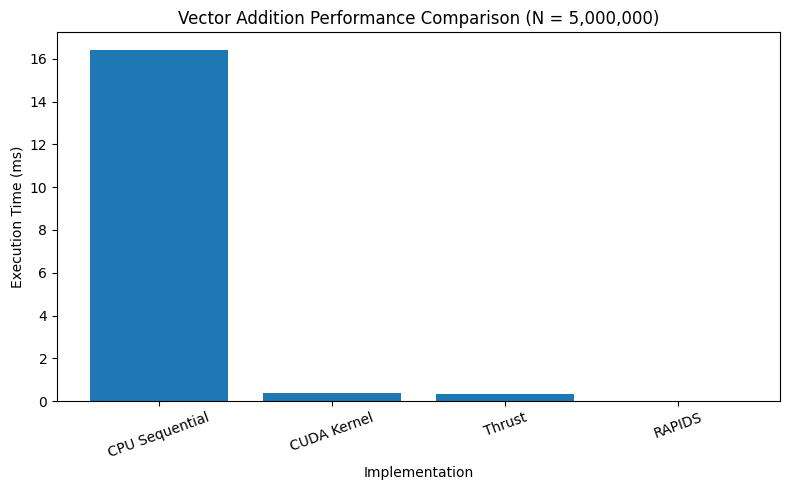

In [27]:
import matplotlib.pyplot as plt
import pandas as pd



cpu_time = 16.415
cuda_time = 0.35751
thrust_time =0.331155
rapids_time = 0.02058863639831543




data = {
    "Method": ["CPU Sequential", "CUDA Kernel", "Thrust", "RAPIDS"],
    "Execution Time (ms)": [cpu_time, cuda_time, thrust_time, rapids_time],
    "Time Complexity": ["O(N)", "O(N)", "O(N)", "O(N)"]
}

df = pd.DataFrame(data)

print("\nPerformance Comparison Table:\n")
print(df.to_string(index=False))



plt.figure(figsize=(8,5))
plt.bar(df["Method"], df["Execution Time (ms)"])
plt.xlabel("Implementation")
plt.ylabel("Execution Time (ms)")
plt.title("Vector Addition Performance Comparison (N = 5,000,000)")
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()

Q6: Write a CUDA C++ program using the Thrust library to compute the sum of
all elements in a vector stored on the GPU. The vector is of size 10 and it
should be ini;alized with values 1,.....10.

In [28]:
%%writefile thrust_sum.cu
#include <iostream>
#include <thrust/device_vector.h>
#include <thrust/reduce.h>

int main() {

    const int N = 10;

    // Create device vector of size 10
    thrust::device_vector<int> d_vec(N);

    // Initialize values 1 to 10
    for(int i = 0; i < N; i++) {
        d_vec[i] = i + 1;
    }

    // Compute sum using thrust::reduce
    int result = thrust::reduce(d_vec.begin(), d_vec.end(), 0, thrust::plus<int>());

    std::cout << "Sum of elements = " << result << std::endl;

    return 0;
}

Writing thrust_sum.cu


In [29]:
!nvcc -arch=sm_75 -std=c++11 thrust_sum.cu -o thrust_sum

In [30]:
!./thrust_sum

Sum of elements = 55


Q7: Write a CUDA C++ program using Thrust to sort (ascending) a vector of
integers on the GPU. Consider vector size 8 with following values: 7, 2, 9, 1, 5, 3, 8, 4. Print the vector before and after sorting.

In [31]:
%%writefile thrust_sort.cu
#include <iostream>
#include <thrust/device_vector.h>
#include <thrust/host_vector.h>
#include <thrust/sort.h>

int main() {

    const int N = 8;

    // Initialize host vector
    thrust::host_vector<int> h_vec(N);

    int values[N] = {7, 2, 9, 1, 5, 3, 8, 4};

    for(int i = 0; i < N; i++) {
        h_vec[i] = values[i];
    }

    std::cout << "Before Sorting:\n";
    for(int i = 0; i < N; i++) {
        std::cout << h_vec[i] << " ";
    }
    std::cout << std::endl;

    // Copy to device
    thrust::device_vector<int> d_vec = h_vec;

    // Sort on GPU
    thrust::sort(d_vec.begin(), d_vec.end());

    // Copy back to host
    h_vec = d_vec;

    std::cout << "After Sorting (Ascending):\n";
    for(int i = 0; i < N; i++) {
        std::cout << h_vec[i] << " ";
    }
    std::cout << std::endl;

    return 0;
}

Writing thrust_sort.cu


In [32]:
!nvcc -arch=sm_75 -std=c++11 thrust_sort.cu -o thrust_sort

In [33]:
!./thrust_sort

Before Sorting:
7 2 9 1 5 3 8 4 
After Sorting (Ascending):
1 2 3 4 5 7 8 9 
